In [1]:
import networkx as nx
import numpy as np
import matplotlib
import matplotlib.pylab as plt
%matplotlib inline
import random as rnd
rnd.seed()
import copy
#import jgraph
from igraph import *
import ConfigModel_MCMC as CM
from sklearn.linear_model import LinearRegression

In [2]:
data_col = "#F19A3E"
ER_col = "#98D9C2"
config_col = "#E75A7C"
mygray = "#65655E"

In [3]:
def drawGz(G,z):
    # DO NOT MODIFY THIS FUNCTION
    # This function draws G with node labels from partition z
    #
    # input  : G is a networkx graph
    #        : z is a dictionary of group labels for G's nodes
    # output : none
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    colors = ['#d61111','#11d646','#11c6d6','#d67711','#1b11d6','#d611cc'] # map node labels to colors (for the visualization)
    
    node_colors = []
    for i in G.nodes():
        if z[i]=='S':
            cid = 0
        if z[i]=='I':
            cid = 1
        if z[i]=='R':
            cid = 2
        node_colors.append(colors[int(cid)])
    nsize  = 600
    flabel = True

    if G.order() > 50:
        nsize  = 100
        flabel = False
    
    nx.draw_kamada_kawai(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it prettier
    #nx.draw_networkx(G,with_labels=flabel,node_size=nsize,width=2,node_color=node_colors) # draw it pretty
    limits=plt.axis('off')                                      # turn off axes
    plt.show() 

    return

In [4]:
def get_avg_degree(g):
    deg_list = []
    for n in g.nodes():
        deg_list.append(g.degree(n))
    return mean(deg_list)

def get_max_degree(g):
    deg_list = []
    for n in g.nodes():
        deg_list.append(g.degree(n))
    return max(deg_list)

In [5]:
# Read in empirical contact data, only including contacts over 10 minutes in total length
# Source: http://www.sociopatterns.org/datasets/high-school-contact-and-friendship-networks/
dir = r'/Users/caseymiddleton/PS2/project/data_graph.csv'
f = open(dir, "rb")
G_data = nx.read_edgelist(f, delimiter=",")
f.close()

G_data.remove_node('\ufeff454') # remove weird spare node?
G_data.to_undirected()

In [6]:
# Create ER random graph
def get_ER(G_data):
    n = len(G_data.nodes())
    k = get_avg_degree(G_data)

    return nx.erdos_renyi_graph(n,k/(n-1), directed=False)

In [7]:
# Create configuration model random graph
def get_config(G_data):
    mcmc_object = CM.MCMC(G_data, allow_loops=False, allow_multi=False, is_vertex_labeled=True,verbose=False)
    return mcmc_object.get_graph()

In [8]:
def get_inf_norm(avg):
    ''' This function returns a random infectiousness on the inverval N(avg,0.1) for a given node '''
    r = rnd.gauss(avg,avg*0.5)
    while r < 0 or r > 1:
        r = rnd.gauss(avg,avg*0.5)
    return r

In [9]:
def get_inf_exp(lam):
    ''' This function returns a random infectiousness on the interval exp(1 / lam) for a given node'''
    r = rnd.expovariate(1/lam)
    while r < 0 or r > 1:
        r = rnd.expovariate(1/lam)
    return r

In [10]:
# Create linear regression model
def lin_regression(x,y):
    ''' lin_regression(x,y): calculates linear regression model using sklearn.linear_model
        x : array of inputs
        y: array of outputs
        Returns a list of 
    '''
    x = np.array(x).reshape((-1, 1)) # inputs are two-dimensional
    y = np.array(y)                  # outputs are one-dimensional
    
    # Create and fit model
    model = LinearRegression(fit_intercept = False).fit(x, y)
    
    # Return array of key model outputs: R^2, 
    return [model.score(x, y), model.intercept_, model.coef_]

In [11]:
sims = 1000

# Plot degree distribution of each graph

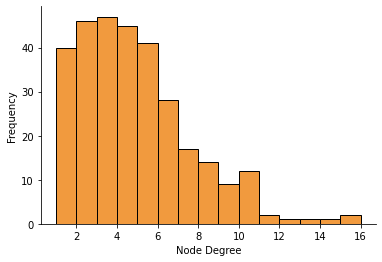

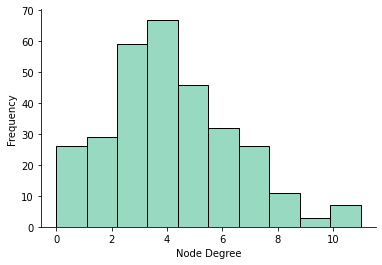

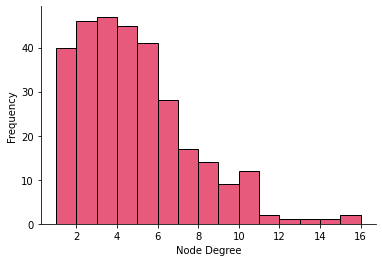

In [12]:
G_ER = get_ER(G_data)
G_config = get_config(G_data)

data_degs = []; ER_degs = []; config_degs = [];
for node in G_data.nodes():
    data_degs.append(G_data.degree(node))
for node in G_ER.nodes():
    ER_degs.append(G_ER.degree(node))
for node in G_config.nodes():
    config_degs.append(G_config.degree(node))

fig1, ax1 = plt.subplots()
ax1.hist(data_degs, bins = 15, color=data_col, edgecolor="black")
ax1.set_xlabel("Node Degree")
ax1.set_ylabel("Frequency")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.savefig("figs/degree_distribution_data.png")

fig2, ax2 = plt.subplots()
ax2.hist(ER_degs, bins = 10, color=ER_col, edgecolor="black")
ax2.set_xlabel("Node Degree")
ax2.set_ylabel("Frequency")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
plt.savefig("figs/degree_distribution_ER.png")

fig3, ax3 = plt.subplots()
ax3.hist(config_degs, bins = 15, color=config_col, edgecolor="black")
ax3.set_xlabel("Node Degree")
ax3.set_ylabel("Frequency")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
plt.savefig("figs/degree_distribution_config.png")

# Simulation with constant infectiousness on ER graph

In [13]:
# Store summary statistics 
max_degree = 100
total_transmissions = np.zeros(max_degree) # number of infected individuals with degree idx 
total_infections = np.zeros(max_degree)    # number of infected individuals with degree idx 
cumulative_transmissions = []              # record all transmissions for each simulation
cumulative_degs = []                       # record all degrees for each simulation
eighty_twenty_rule = []                    # what percentage of individuals caused 80% of infections

max_degree = 0

for ii in range(1,sims):
    G_ER = get_ER(G_data)
    n = len(G_ER.nodes())
        
    sim_transmissions = [] # number of infected individuals with degree idx 
    sim_degs = []          # number of infected individuals with degree idx 
    
    # track node information 
    k = get_avg_degree(G_ER)
    if get_max_degree(G_ER) > max_degree: max_degree = get_max_degree(G_ER)
    zt = dict.fromkeys(range(n), 'S') # all nodes S, initially
    inf = dict.fromkeys(range(n), 0) # node infectiousness
    transmissions = dict.fromkeys(range(n), 0) # number of secondary infections caused by that node
    infected = dict.fromkeys(range(n), 0) # whether node has been infected or not

    R0 = 4 # avg number of secondary infections from 1 index case
    gmma = 1/6 # 6 day recovery period
    beta = R0*gmma/k # transmissibility

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t

    # pick a random node as patient 0
    seed           = int(rnd.randint(0,n-1)) 
    zt[seed]       = 'I'
    infected[seed] = 1
    t              = 1

    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G_ER.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() <= beta:
                    zu[j] = 'I'       # i infects j for next round
                    transmissions[i] += 1 
                    infected[j] = 1
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() <= beta:
                    zu[i] = 'I'       # j infects i for next round
                    transmissions[j] += 1 
                    infected[i] = 1
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G_ER.nodes():
            if zt[i] == 'I' and rnd.random() <= gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    # Show final graph
    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    # Unpack number of secondary infections from those who were infected to store in data for all sims
    transmission_count = []
    for id in infected:
        if infected[id] == 1:
            # Store sim data in list where index = deg 
            idx = G_ER.degree(id)
            total_transmissions[idx] += transmissions[id]
            total_infections[idx] += 1
            transmission_count.append(transmissions[id])
            sim_degs.append(idx)
            sim_transmissions.append(transmissions[id])

    # Address the 80/20 rule
    tot_inf = sum(transmission_count)
    pct_infs = 0
    who_caused = 0
    
    if tot_inf > 0:
        while pct_infs < 0.8:
            max_val = max(transmission_count)
            #max_index = trans.index(max_val)

            pct_infs += max_val / tot_inf
            who_caused += 1/n
            transmission_count.remove(max_val)
    else:
        who_caused = 0

    eighty_twenty_rule.append(who_caused)
    cumulative_transmissions.append(sim_transmissions)
    cumulative_degs.append(sim_degs)


In [14]:
mean(eighty_twenty_rule)

0.2334622203903246

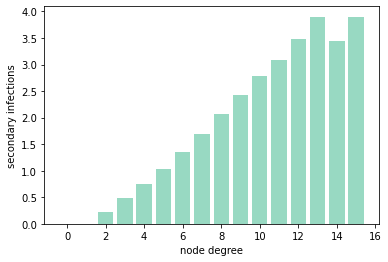

In [15]:
# Bar chart of transmissions
total_transmissions = total_transmissions[0:max_degree]
total_infections = total_infections[0:max_degree]

avg_transmissions = [total_transmissions[i] / max(total_infections[i],1) for i in np.arange(0,len(total_infections))]
degs = np.arange(0,len(avg_transmissions))

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.bar(degs, avg_transmissions, color=ER_col)  
plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/Ri_deg_constantinf_ER.png")

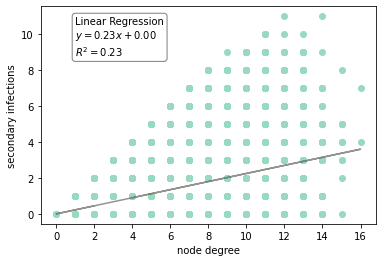

In [16]:
# Scatter plot of transmission events with linear regression model 
flat_degs = [item for sublist in cumulative_degs for item in sublist]
flat_transmissions = [item for sublist in cumulative_transmissions for item in sublist]

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_degs, flat_transmissions)
trans_pred = slope * flat_degs + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_degs, flat_transmissions, color=ER_col)  
plt.plot(flat_degs, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(1,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_deg_constantinf_ER.png")

# Simulation with constant infectiousness on configuration model

In [17]:
# Store summary statistics 
max_degree = 100
total_transmissions = np.zeros(max_degree) # number of infected individuals with degree idx 
total_infections = np.zeros(max_degree)    # number of infected individuals with degree idx 
cumulative_transmissions = []              # record all transmissions for each simulation
cumulative_degs = []                       # record all degrees for each simulation
eighty_twenty_rule = []                    # what percentage of individuals caused 80% of infections

max_degree = 0

for ii in range(1,sims):
    G_config = get_config(G_data)
    n = len(G_config.nodes())
        
    sim_transmissions = [] # number of infected individuals with degree idx 
    sim_degs = []          # number of infected individuals with degree idx 
    
    # track node information 
    k = get_avg_degree(G_config)
    if get_max_degree(G_ER) > max_degree: max_degree = get_max_degree(G_ER)
    zt = {node : 'S' for node in G_config.nodes()} # all nodes S, initially
    inf = {node : 0 for node in G_config.nodes()} # node infectiousness
    transmissions = {node : 0 for node in G_config.nodes()} # number of secondary infections caused by that node
    infected = {node : 0 for node in G_config.nodes()} # whether node has been infected or not
    
    R0 = 4 # avg number of secondary infections from 1 index case
    gmma = 1/6 # 6 day recovery period
    beta = R0*gmma/k # transmissibility

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t

    # pick a random node as patient 0
    node_list = [node for node in G_config.nodes()]
    seed           = int(rnd.randint(0,n-1)) 
    seed           = node_list[seed]
    zt[seed]       = 'I'
    infected[seed] = 1
    t              = 1

    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G_config.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() <= beta:
                    zu[j] = 'I'       # i infects j for next round
                    transmissions[i] += 1 
                    infected[j] = 1
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() <= beta:
                    zu[i] = 'I'       # j infects i for next round
                    transmissions[j] += 1 
                    infected[i] = 1
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G_config.nodes():
            if zt[i] == 'I' and rnd.random() <= gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    # Show final graph
    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    # Unpack number of secondary infections from those who were infected to store in data for all sims
    transmission_count = []
    for id in infected:
        if infected[id] == 1:
            # Store sim data in list where index = deg 
            idx = G_config.degree(id)
            total_transmissions[idx] += transmissions[id]
            total_infections[idx] += 1
            transmission_count.append(transmissions[id])
            sim_degs.append(idx)
            sim_transmissions.append(transmissions[id])

    # Address the 80/20 rule
    tot_inf = sum(transmission_count)
    pct_infs = 0
    who_caused = 0
    
    if tot_inf > 0:
        while pct_infs < 0.8:
            max_val = max(transmission_count)
            #max_index = trans.index(max_val)

            pct_infs += max_val / tot_inf
            who_caused += 1/n
            transmission_count.remove(max_val)
    else:
        who_caused = 0

    eighty_twenty_rule.append(who_caused)
    cumulative_transmissions.append(sim_transmissions)
    cumulative_degs.append(sim_degs)


In [18]:
mean(eighty_twenty_rule)

0.20122737116201145

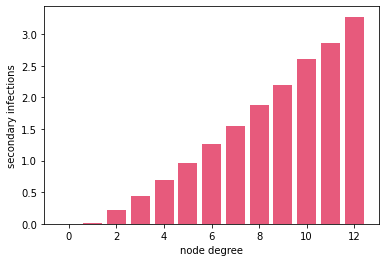

In [19]:
# Bar chart of transmissions
total_transmissions = total_transmissions[0:max_degree]
total_infections = total_infections[0:max_degree]

avg_transmissions = [total_transmissions[i] / max(total_infections[i],1) for i in np.arange(0,len(total_infections))]
degs = np.arange(0,len(avg_transmissions))

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.bar(degs, avg_transmissions, color=config_col)  
plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/Ri_deg_constantinf_config.png")

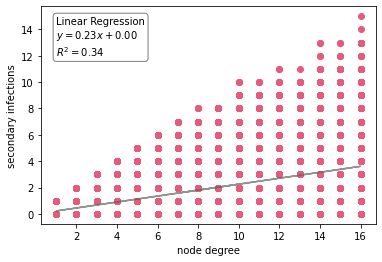

In [20]:
# Scatter plot of transmission events with linear regression model 
flat_degs = [item for sublist in cumulative_degs for item in sublist]
flat_transmissions = [item for sublist in cumulative_transmissions for item in sublist]

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_degs, flat_transmissions)
trans_pred = slope * flat_degs + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_degs, flat_transmissions, color=config_col)  
plt.plot(flat_degs, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(1,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_deg_constantinf_config.png")

# Simulation with random (normal) infectiousness and ER graph

In [21]:
# Store summary statistics 
max_degree = 100
total_transmissions = np.zeros(max_degree) # number of infected individuals with degree idx 
total_infections = np.zeros(max_degree)    # number of infected individuals with degree idx 
cumulative_transmissions = []              # record all transmissions for each simulation
cumulative_degs = []                       # record all degrees for each simulation
cumulative_infectiousness = []             # record all node infectiousness for each simulation
eighty_twenty_rule = []                    # what percentage of individuals caused 80% of infections

max_degree = 0

for ii in range(1,sims):
    G_ER = get_ER(G_data)
    n = len(G_ER.nodes())
        
    sim_transmissions = [] # list of transmission counts for each node
    sim_degs = []          # list of degrees for transmission events
    sim_infectiousness = []# list of infectiousness for transmission events
    
    # track node information 
    k = get_avg_degree(G_ER)
    if get_max_degree(G_ER) > max_degree: max_degree = get_max_degree(G_ER)
    zt = dict.fromkeys(range(n), 'S') # all nodes S, initially
    inf = dict.fromkeys(range(n), 0) # node infectiousness
    transmissions = dict.fromkeys(range(n), 0) # number of secondary infections caused by that node
    infected = dict.fromkeys(range(n), 0) # whether node has been infected or not

    R0 = 4 # avg number of secondary infections from 1 index case
    gmma = 1/6 # 6 day recovery period
    beta = R0*gmma/k # transmissibility

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t

    # pick a random node as patient 0
    seed           = int(rnd.randint(0,n-1)) 
    zt[seed]       = 'I'
    infected[seed] = 1
    t              = 1
    inf[seed]      = get_inf_norm(beta) # set random infectiousness

    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G_ER.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() <= inf[i]:
                    zu[j] = 'I'       # i infects j for next round
                    transmissions[i] += 1 
                    infected[j] = 1
                    inf[j] = get_inf_norm(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() <= inf[j]:
                    zu[i] = 'I'       # j infects i for next round
                    transmissions[j] += 1 
                    infected[i] = 1
                    inf[i] = get_inf_norm(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G_ER.nodes():
            if zt[i] == 'I' and rnd.random() <= gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    # Show final graph
    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    # Unpack number of secondary infections from those who were infected to store in data for all sims
    transmission_count = []
    for id in infected:
        if infected[id] == 1:
            # Store sim data in list where index = deg 
            idx = G_ER.degree(id)
            total_transmissions[idx] += transmissions[id]
            total_infections[idx] += 1
            transmission_count.append(transmissions[id])
            sim_degs.append(idx)
            sim_transmissions.append(transmissions[id])
            sim_infectiousness.append(inf[id])

    # Address the 80/20 rule
    tot_inf = sum(transmission_count)
    pct_infs = 0
    who_caused = 0
    
    if tot_inf > 0:
        while pct_infs < 0.8:
            max_val = max(transmission_count)
            #max_index = trans.index(max_val)

            pct_infs += max_val / tot_inf
            who_caused += 1/n
            transmission_count.remove(max_val)
    else:
        who_caused = 0

    eighty_twenty_rule.append(who_caused)
    cumulative_transmissions.append(sim_transmissions)
    cumulative_degs.append(sim_degs)
    cumulative_infectiousness.append(sim_infectiousness)


In [22]:
mean(eighty_twenty_rule)

0.2047962995675411

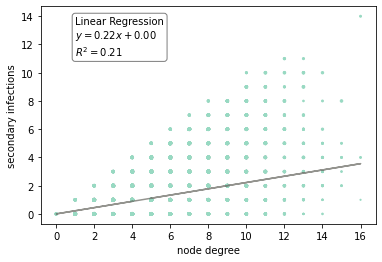

In [23]:
# Scatter plot of transmission events + node degree with linear regression model 
flat_degs = [item for sublist in cumulative_degs for item in sublist]
flat_transmissions = [item for sublist in cumulative_transmissions for item in sublist]
flat_infectiousness = [item for sublist in cumulative_infectiousness for item in sublist]

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_degs, flat_transmissions)
trans_pred = slope * flat_degs + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_degs, flat_transmissions, color=ER_col, s=np.multiply(flat_infectiousness,20))  
plt.plot(flat_degs, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(1,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_deg_normalinf_ER.png")

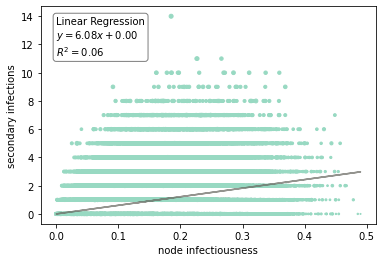

In [24]:
# Scatter plot of transmission events + node degree with linear regression model 

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_infectiousness, flat_transmissions)
trans_pred = slope * flat_infectiousness + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_infectiousness, flat_transmissions, color=ER_col, s=flat_degs)  
plt.plot(flat_infectiousness, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node infectiousness')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_inf_normalinf_ER.png")

# Simulation with normal infectiousness on configuration model

In [25]:
# Store summary statistics 
max_degree = 100
total_transmissions = np.zeros(max_degree) # number of infected individuals with degree idx 
total_infections = np.zeros(max_degree)    # number of infected individuals with degree idx 
cumulative_transmissions = []              # record all transmissions for each simulation
cumulative_degs = []                       # record all degrees for each simulation
cumulative_infectiousness = []             # record all node infectiousness for each simulation
eighty_twenty_rule = []                    # what percentage of individuals caused 80% of infections

max_degree = 0

for ii in range(1,sims):
    G_config = get_config(G_data)
    n = len(G_config.nodes())
         
    sim_transmissions = [] # list of transmission counts for each node
    sim_degs = []          # list of degrees for transmission events
    sim_infectiousness = []# list of infectiousness for transmission events
    
    
    # track node information 
    k = get_avg_degree(G_config)
    if get_max_degree(G_ER) > max_degree: max_degree = get_max_degree(G_ER)
    zt = {node : 'S' for node in G_config.nodes()} # all nodes S, initially
    inf = {node : 0 for node in G_config.nodes()} # node infectiousness
    transmissions = {node : 0 for node in G_config.nodes()} # number of secondary infections caused by that node
    infected = {node : 0 for node in G_config.nodes()} # whether node has been infected or not
    
    R0 = 4 # avg number of secondary infections from 1 index case
    gmma = 1/6 # 6 day recovery period
    beta = R0*gmma/k # transmissibility

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t

    # pick a random node as patient 0
    node_list = [node for node in G_config.nodes()]
    seed           = int(rnd.randint(0,n-1)) 
    seed           = node_list[seed]
    zt[seed]       = 'I'
    infected[seed] = 1
    t              = 1
    inf[seed]      = get_inf_norm(beta) # set random infectiousness

    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G_config.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() <= inf[i]:
                    zu[j] = 'I'       # i infects j for next round
                    transmissions[i] += 1 
                    infected[j] = 1
                    inf[j] = get_inf_norm(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() <= inf[j]:
                    zu[i] = 'I'       # j infects i for next round
                    transmissions[j] += 1 
                    infected[i] = 1
                    inf[i] = get_inf_norm(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G_config.nodes():
            if zt[i] == 'I' and rnd.random() <= gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    # Show final graph
    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    # Unpack number of secondary infections from those who were infected to store in data for all sims
    transmission_count = []
    for id in infected:
        if infected[id] == 1:
            # Store sim data in list where index = deg 
            idx = G_config.degree(id)
            total_transmissions[idx] += transmissions[id]
            total_infections[idx] += 1
            transmission_count.append(transmissions[id])
            sim_degs.append(idx)
            sim_transmissions.append(transmissions[id])
            sim_infectiousness.append(inf[id])

    # Address the 80/20 rule
    tot_inf = sum(transmission_count)
    pct_infs = 0
    who_caused = 0
    
    if tot_inf > 0:
        while pct_infs < 0.8:
            max_val = max(transmission_count)
            #max_index = trans.index(max_val)

            pct_infs += max_val / tot_inf
            who_caused += 1/n
            transmission_count.remove(max_val)
    else:
        who_caused = 0

    eighty_twenty_rule.append(who_caused)
    cumulative_transmissions.append(sim_transmissions)
    cumulative_degs.append(sim_degs)
    cumulative_infectiousness.append(sim_infectiousness)


In [26]:
mean(eighty_twenty_rule)

0.1744555012528867

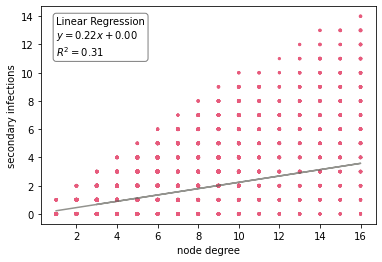

In [27]:
# Scatter plot of transmission events + node degree with linear regression model 
flat_degs = [item for sublist in cumulative_degs for item in sublist]
flat_transmissions = [item for sublist in cumulative_transmissions for item in sublist]
flat_infectiousness = [item for sublist in cumulative_infectiousness for item in sublist]


# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_degs, flat_transmissions)
trans_pred = slope * flat_degs + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_degs, flat_transmissions, color=config_col, s=np.multiply(flat_infectiousness,20))  
plt.plot(flat_degs, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(1,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_deg_normalinf_config.png")

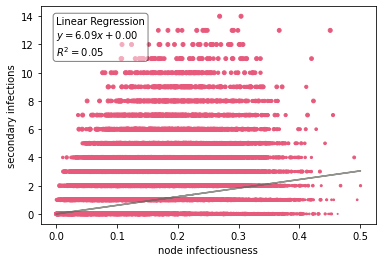

In [28]:
# Scatter plot of transmission events + node degree with linear regression model 

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_infectiousness, flat_transmissions)
trans_pred = slope * flat_infectiousness + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_infectiousness, flat_transmissions, color=config_col, s=flat_degs)  
plt.plot(flat_infectiousness, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node infectiousness')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_inf_normalinf_config.png")

# Simulation with exponential infectiousness and ER graph

In [13]:
# Store summary statistics 
max_degree = 100
total_transmissions = np.zeros(max_degree) # number of infected individuals with degree idx 
total_infections = np.zeros(max_degree)    # number of infected individuals with degree idx 
cumulative_transmissions = []              # record all transmissions for each simulation
cumulative_degs = []                       # record all degrees for each simulation
cumulative_infectiousness = []             # record all node infectiousness for each simulation
eighty_twenty_rule = []                    # what percentage of individuals caused 80% of infections

max_degree = 0

for ii in range(1,sims):
    G_ER = get_ER(G_data)
    n = len(G_ER.nodes())
        
    sim_transmissions = [] # list of transmission counts for each node
    sim_degs = []          # list of degrees for transmission events
    sim_infectiousness = []# list of infectiousness for transmission events
    
    # track node information 
    k = get_avg_degree(G_ER)
    if get_max_degree(G_ER) > max_degree: max_degree = get_max_degree(G_ER)
    zt = dict.fromkeys(range(n), 'S') # all nodes S, initially
    inf = dict.fromkeys(range(n), 0) # node infectiousness
    transmissions = dict.fromkeys(range(n), 0) # number of secondary infections caused by that node
    infected = dict.fromkeys(range(n), 0) # whether node has been infected or not

    R0 = 4 # avg number of secondary infections from 1 index case
    gmma = 1/6 # 6 day recovery period
    beta = R0*gmma/k # transmissibility

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t

    # pick a random node as patient 0
    seed           = int(rnd.randint(0,n-1)) 
    zt[seed]       = 'I'
    infected[seed] = 1
    t              = 1
    inf[seed]      = get_inf_exp(beta) # set random infectiousness

    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G_ER.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() <= inf[i]:
                    zu[j] = 'I'       # i infects j for next round
                    transmissions[i] += 1 
                    infected[j] = 1
                    inf[j] = get_inf_exp(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() <= inf[j]:
                    zu[i] = 'I'       # j infects i for next round
                    transmissions[j] += 1 
                    infected[i] = 1
                    inf[i] = get_inf_exp(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G_ER.nodes():
            if zt[i] == 'I' and rnd.random() <= gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    # Show final graph
    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    # Unpack number of secondary infections from those who were infected to store in data for all sims
    transmission_count = []
    for id in infected:
        if infected[id] == 1:
            # Store sim data in list where index = deg 
            idx = G_ER.degree(id)
            total_transmissions[idx] += transmissions[id]
            total_infections[idx] += 1
            transmission_count.append(transmissions[id])
            sim_degs.append(idx)
            sim_transmissions.append(transmissions[id])
            sim_infectiousness.append(inf[id])

    # Address the 80/20 rule
    tot_inf = sum(transmission_count)
    pct_infs = 0
    who_caused = 0
    
    if tot_inf > 0:
        while pct_infs < 0.8:
            max_val = max(transmission_count)
            #max_index = trans.index(max_val)

            pct_infs += max_val / tot_inf
            who_caused += 1/n
            transmission_count.remove(max_val)
    else:
        who_caused = 0

    eighty_twenty_rule.append(who_caused)
    cumulative_transmissions.append(sim_transmissions)
    cumulative_degs.append(sim_degs)
    cumulative_infectiousness.append(sim_infectiousness)


In [14]:
mean(eighty_twenty_rule)

0.11564178557642586

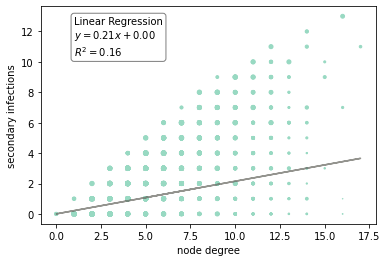

In [15]:
# Scatter plot of transmission events + node degree with linear regression model 
flat_degs = [item for sublist in cumulative_degs for item in sublist]
flat_transmissions = [item for sublist in cumulative_transmissions for item in sublist]
flat_infectiousness = [item for sublist in cumulative_infectiousness for item in sublist]

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_degs, flat_transmissions)
trans_pred = slope * flat_degs + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_degs, flat_transmissions, color=ER_col, s=np.multiply(flat_infectiousness,20))  
plt.plot(flat_degs, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(1,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_deg_expinf_ER.png")

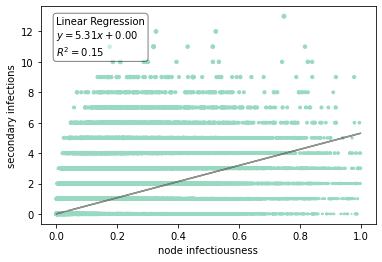

In [16]:
# Scatter plot of transmission events + node degree with linear regression model 

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_infectiousness, flat_transmissions)
trans_pred = slope * flat_infectiousness + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_infectiousness, flat_transmissions, color=ER_col, s=flat_degs)  
plt.plot(flat_infectiousness, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node infectiousness')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_inf_expinf_ER.png")

# Simulation with normal infectiousness on configuration model

In [17]:
# Store summary statistics 
max_degree = 100
total_transmissions = np.zeros(max_degree) # number of infected individuals with degree idx 
total_infections = np.zeros(max_degree)    # number of infected individuals with degree idx 
cumulative_transmissions = []              # record all transmissions for each simulation
cumulative_degs = []                       # record all degrees for each simulation
cumulative_infectiousness = []             # record all node infectiousness for each simulation
eighty_twenty_rule = []                    # what percentage of individuals caused 80% of infections

max_degree = 0

for ii in range(1,sims):
    G_config = get_config(G_data)
    n = len(G_config.nodes())
         
    sim_transmissions = [] # list of transmission counts for each node
    sim_degs = []          # list of degrees for transmission events
    sim_infectiousness = []# list of infectiousness for transmission events
    
    
    # track node information 
    k = get_avg_degree(G_config)
    if get_max_degree(G_ER) > max_degree: max_degree = get_max_degree(G_ER)
    zt = {node : 'S' for node in G_config.nodes()} # all nodes S, initially
    inf = {node : 0 for node in G_config.nodes()} # node infectiousness
    transmissions = {node : 0 for node in G_config.nodes()} # number of secondary infections caused by that node
    infected = {node : 0 for node in G_config.nodes()} # whether node has been infected or not
    
    R0 = 4 # avg number of secondary infections from 1 index case
    gmma = 1/6 # 6 day recovery period
    beta = R0*gmma/k # transmissibility

    St = [] # S(t), time series of number of S nodes per time step t
    It = [] # I(t), time series of number of I nodes per time step t
    Rt = [] # R(t), time series of number of R nodes per time step t

    # pick a random node as patient 0
    node_list = [node for node in G_config.nodes()]
    seed           = int(rnd.randint(0,n-1)) 
    seed           = node_list[seed]
    zt[seed]       = 'I'
    infected[seed] = 1
    t              = 1
    inf[seed]      = get_inf_exp(beta) # set random infectiousness

    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    Sc,Ic,Rc = n-1,1,0 # S,I,R node counts, initial
    St.append(Sc)
    It.append(Ic)
    Rt.append(Rc)
    while any(xi == 'I' for xi in zt.values()):
        zu = copy.deepcopy(zt) # nodes states for next time step (synchronous updates)

        # do S -> I transitions
        for e in G_config.edges():
            i,j = e[0],e[1]           # this edge (i,j)
            if zt[i]=='I' and zt[j]=='S' and zu[j]!='I':
                if rnd.random() <= inf[i]:
                    zu[j] = 'I'       # i infects j for next round
                    transmissions[i] += 1 
                    infected[j] = 1
                    inf[j] = get_inf_exp(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

            if zt[i]=='S' and zt[j]=='I' and zu[i]!='I':
                if rnd.random() <= inf[j]:
                    zu[i] = 'I'       # j infects i for next round
                    transmissions[j] += 1 
                    infected[i] = 1
                    inf[i] = get_inf_exp(beta)
                    Sc,Ic = Sc-1,Ic+1 # update counts

        # do I -> R transitions
        for i in G_config.nodes():
            if zt[i] == 'I' and rnd.random() <= gmma:
                zu[i] = 'R'           # i recovers (R)
                Ic,Rc = Ic-1,Rc+1     # update counts

        # update all states synchronously, update clock
        zt = copy.deepcopy(zu)
        t  = t+1

        St.append(Sc)
        It.append(Ic)
        Rt.append(Rc) # append these counts to the time series

    # Show final graph
    #print(f'time step {t}')
    #drawGz(G_ER,zt)

    # Unpack number of secondary infections from those who were infected to store in data for all sims
    transmission_count = []
    for id in infected:
        if infected[id] == 1:
            # Store sim data in list where index = deg 
            idx = G_config.degree(id)
            total_transmissions[idx] += transmissions[id]
            total_infections[idx] += 1
            transmission_count.append(transmissions[id])
            sim_degs.append(idx)
            sim_transmissions.append(transmissions[id])
            sim_infectiousness.append(inf[id])

    # Address the 80/20 rule
    tot_inf = sum(transmission_count)
    pct_infs = 0
    who_caused = 0
    
    if tot_inf > 0:
        while pct_infs < 0.8:
            max_val = max(transmission_count)
            #max_index = trans.index(max_val)

            pct_infs += max_val / tot_inf
            who_caused += 1/n
            transmission_count.remove(max_val)
    else:
        who_caused = 0

    eighty_twenty_rule.append(who_caused)
    cumulative_transmissions.append(sim_transmissions)
    cumulative_degs.append(sim_degs)
    cumulative_infectiousness.append(sim_infectiousness)


In [18]:
mean(eighty_twenty_rule)

0.10245212532794214

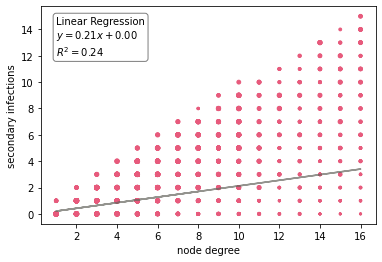

In [19]:
# Scatter plot of transmission events + node degree with linear regression model 
flat_degs = [item for sublist in cumulative_degs for item in sublist]
flat_transmissions = [item for sublist in cumulative_transmissions for item in sublist]
flat_infectiousness = [item for sublist in cumulative_infectiousness for item in sublist]


# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_degs, flat_transmissions)
trans_pred = slope * flat_degs + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_degs, flat_transmissions, color=config_col, s=np.multiply(flat_infectiousness,20))  
plt.plot(flat_degs, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(1,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node degree')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_deg_expinf_config.png")

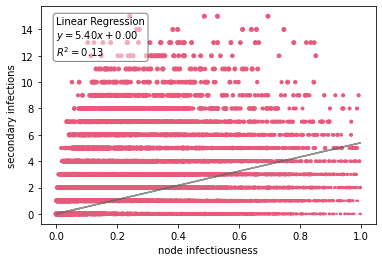

In [20]:
# Scatter plot of transmission events + node degree with linear regression model 

# Calculate linear regression model 
r_sq, intercept, slope = lin_regression(flat_infectiousness, flat_transmissions)
trans_pred = slope * flat_infectiousness + intercept

fig = plt.figure()
ax1 = fig.add_subplot(111) 
plt.scatter(flat_infectiousness, flat_transmissions, color=config_col, s=flat_degs)  
plt.plot(flat_infectiousness, trans_pred, color = mygray, alpha=0.7)

txtbox = '\n'.join((
    r'Linear Regression',
    r'$y=%.2f x + %.2f$' % (slope, intercept, ),
    r'$R^2=%.2f$' % (r_sq, )))
box = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax1.text(0,max(flat_transmissions),txtbox, verticalalignment="top", bbox=box)

plt.ylabel('secondary infections')
plt.xlabel('node infectiousness')
#plt.ylim([0,np.max(transmission_count)+1])

plt.savefig("figs/regression_inf_expinf_config.png")

In [ ]:
install 